In [150]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, Dense, Reshape 
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.models import load_model
from numpy import asarray
from numpy import save
from numpy import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import esprima as esp
import re
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model
from keras import Model
import keras
import pydot
import gensim 
from nltk.tokenize import word_tokenize
import pickle
from keras import backend as K

plt.style.use('ggplot')

In [141]:
def save_object(obj, filename):
    with open(filename+".pickle", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

In [142]:
def load_object(filename):
    with open(filename+".pickle", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [143]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [144]:
def preprocessing_dataset_(scripts,test = 0):
    if test == 0:
        tokenizer = Tokenizer(num_words=num_words)
        tokenizer.fit_on_texts(scripts)
        our_tokenizer = save_object(tokenizer, "our_tokenizer")
    else :
        tokenizer = load_object("our_tokenizer")
    X = tokenizer.texts_to_sequences(scripts)
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
    save_object(vocab_size, "vocab_size")
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    return X

In [145]:
# convert java script code to the abstract syntax tree
# then extract the sequences of syntax units with detailed information
def sequence_of_syntax_units(scripts):
    """
    sctipts : list or single javascript code 
    return sequence of syntax units
    each syntax unit correspond to line in an abstract syntax tree
    """
    if type(scripts) is list:
        # esp.parseScript(script) returns abstract syntax tree of each js scripts
        return [re.sub('\s+', ' ', ''.join(str(esp.parseScript(script)).split('\n'))) for script in scripts]
    elif type(scripts) is str:
        return re.sub('\s+', ' ', ''.join(str(esp.parseScript(scripts)).split('\n')))
    else:
        raise ValueError('The type of scripts parameter must be {list or string}')

In [146]:
# create word tokens
def sequence_of_syntax_units_to_tokens(seq_of_syn_units):
    """
    Convert Sequence of syntax units to tokens to train  word2vec model 
    -----------------------------------------
    seq_of_syn_units: list of sequence syntax units correspond to abstract syntax trees
    """
    return list(map(word_tokenize, seq_of_syn_units))

In [147]:
def extract_js_code_with_no_tag(code):
    return  list(map(lambda x: re.sub(r';', ' ; ', x), re.findall(r'javascript:(.*?\(.*?\))[\\/<>]?', code, re.IGNORECASE)))

In [148]:
 def extract_js_code(script):
    #list all the scripts tags
    internal_js = re.findall(r'<script>?(.*?\(.*?\))[\\/<>]?',script , re.IGNORECASE)
    # remove unwanted words like javascript keyword and quotes 
    # add space befor and after semicolon
    clean_js_codes = []
    for code in internal_js:
        if re.search(r'javascript', code):
            clean_js_codes += extract_js_code_with_no_tag(code)  
        else:
            clean_js_codes.append(re.sub(r';', ' ; ', code))
    r = list(set(clean_js_codes + extract_js_code_with_no_tag(script)))
    if len(r) == 0:
        print(script)
    return r

In [149]:
class CustomDataGen(keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,batch_size,test=0,shuffle=True,sub_path=""):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.sub_path = sub_path
        self.n = len(self.df[self.df.columns[0]])
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        try:
            with open(self.sub_path+path) as js_file:
                script = js_file.read()
            script = sequence_of_syntax_units(script)
            return script
        except:
            return 'None'
    def __get_output(self, label):
        return label
#         return keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batches):

        path_batch = batches[self.X_col['path']]
        
        name_batch = batches[self.y_col['name']]

        X_batch = np.asarray([self.__get_input(x) for x in path_batch]).astype('object')
        
        y_batch = np.asarray([self.__get_output(y) for y in name_batch]).astype('object')
        
        index = np.where(X_batch=='None')[0]
        
        np.delete(X_batch, index, axis=0)
        np.delete(y_batch, index, axis=0)
        
        X_batch  = preprocessing_dataset_(X_batch , test = self.test )
        
        X_batch = K.cast_to_floatx(X_batch)
        y_batch = K.cast_to_floatx(y_batch)
        

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [158]:
def evaluation(model,history,X_train,X_test):    
    loss, accuracy = model.evaluate_generator(X_train)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate_generator(X_test)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plot_history(history)

In [160]:
def evaluation_(model,history,X_train,y_train,X_test=0,y_test=0,with_test=False):
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    if with_test:
        loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
        print("Testing Accuracy:  {:.4f}".format(accuracy))
        print(classification_report(np.round(model.predict(X_test)), y_test))
    plot_history(history)

In [161]:
def Model(shape=100,Type=0):
    model = Sequential()
    if Type==0:
        model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
        model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
    else :
         model.add(layers.InputLayer(input_shape=shape))
        
    
    model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))

    # TextCNN with 4 conv layers
    model.add(Conv1D(128, 7, activation='tanh', input_shape=(None, 32)))
    model.add(Conv1D(128, 15, activation='tanh'))
    model.add(Conv1D(128, 25, activation='tanh'))
    model.add(Conv1D(128, 35, activation='tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=myoptimizer,
                  loss=myloss,
                  metrics=[mymetrics])
    model.summary()
    return model

In [162]:
def fit_model(model,model_name,training_generator,validation_data=0,with_test=False):
    model_name = str(model_name)+".h5"
    if with_test:
        history = model.fit_generator(generator=training_generator,epochs=10,verbose=False,validation_data=validation_data)
    else:
        history = model.fit_generator(generator=training_generator,epochs=10,verbose=False)
    model.save(model_name)
    return model , history , model_name

In [163]:
def fit_model_(model,model_name,X_train,y_train,X_test=0,y_test=0,with_test=False):
    model_name = str(model_name)+".h5"
    if with_test:
        history = model.fit(X_train, y_train,epochs=10,verbose=False,validation_data=(X_test, y_test))
    else:
        history = model.fit(X_train, y_train,epochs=10,verbose=False)
    model.save(model_name)
    return model , history , model_name

In [154]:
my_df = pd.read_csv('G:/JSContanaDataSet/script_path_data.csv')
my_test_df = pd.read_csv('G:/JSContanaDataSet/script_path_test_data.csv')

my_batch_size = 20
path_train_data = 'G:/JSContanaDataSet/script__df.csv'
# num_words = 400000
num_words = 400
# maxlen = 1024
maxlen = 100
embedding_dim = 50
myoptimizer = 'adam'
myloss= 'binary_crossentropy'
mymetrics = 'accuracy'

traingen = CustomDataGen(my_df.sample(1000),
                         X_col={'path':'ScriptPath'},
                         y_col={'name': 'Label'},
                         batch_size=my_batch_size,
                         sub_path='G:/JSContanaDataSet/',
                         test=0)

testgen = CustomDataGen(my_test_df.sample(500),
                         X_col={'path':'ScriptPath'},
                         y_col={'name': 'Label'},
                         batch_size=my_batch_size,
                         sub_path='G:/JSContanaDataSet/',
                         test=1)

vocab_size = load_object('vocab_size')


In [17]:
#################################traingen##################################

In [24]:
# keras_function = K.function([Model_for_all_for_traingen.input], [Model_for_all_data.layers[1].output])
# for_traingen = []
# for i in range(int(my_df.sample(1000).shape[0]/my_batch_size)):
#     first_layer_output.append(keras_function([list(traingen)[i][0], 1]))
#     for_traingen.append((first_layer_output[0],list(traingen)[i][1]))

# save_object(for_traingen, "for_traingen_")

In [25]:
# for_traingen[0][0][0].shape

In [26]:
# list(traingen)[0][0].shape

In [27]:
# clear_session()

In [28]:
#################################testgen##################################

In [29]:
# Model_for_all_for_testgen = Model()

In [30]:
# Model_for_all_for_testgen , history , model_name = fit_model(Model_for_all_for_testgen,"Model_for_for_testgen",testgen,with_test=0)

In [31]:
# keras_function = K.function([Model_for_all_for_testgen.input], [Model_for_all_for_testgen.layers[1].output])
# for_testgen = []
# for i in range(my_batch_size):
#     first_layer_output = keras_function([list(testgen)[i][0], 1])
#     for_testgen.append((first_layer_output[0],list(testgen)[i][1]))

# save_object(for_testgen, "for_testgen")
# for_testgen = load_object("for_testgen")

In [32]:
# clear_session()

In [33]:
#################################traingen,testgen##################################

In [34]:
train_test_Model = Model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           103150    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 128)           89728     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 56, 128)           409728    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 128)           5

In [35]:
train_test_Model , train_test_Model_history , train_test_Model_model_name = fit_model(train_test_Model,"train_test_Model",traingen,testgen,with_test=1)

Instructions for updating:
Please use Model.fit, which supports generators.


Training Accuracy: 0.5140
Testing Accuracy:  0.5000


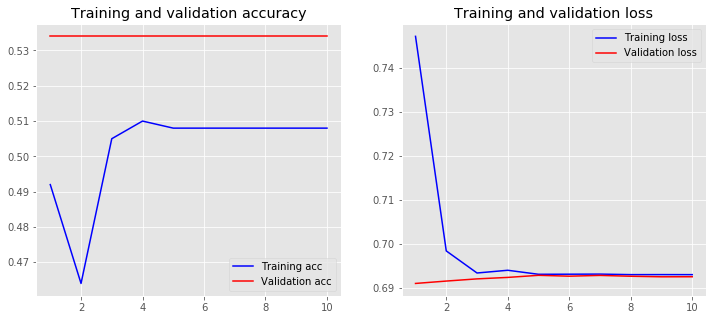

In [159]:
evaluation(train_test_Model,train_test_Model_history,traingen,testgen)

In [40]:
keras_function = K.function([train_test_Model.input], [train_test_Model.layers[1].output])
for_traingen = []
for i in range(int(my_df.sample(1000).shape[0]/my_batch_size)):
    first_layer_output = keras_function([list(traingen)[i][0], 1])
    for_traingen.append(first_layer_output[0])
_for_traingen_ = for_traingen[0]
for i in for_traingen[1:]:
    _for_traingen_ = np.concatenate((_for_traingen_, i), axis=0)
# save_object(_for_traingen_, "_for_traingen_")
_for_traingen_ = load_object("_for_traingen_")

In [ ]:
#######################################################

In [92]:
Model_without_first_layer = Model(shape=_for_traingen_[0].shape,Type=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 100)          60400     
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 128)           89728     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 56, 128)           409728    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 128)           573568    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8

In [137]:
Model_without_first_layer,history_Model_without_first_layer,name_Model_without_first_layer=fit_model_(Model_without_first_layer,"Model_without_first_layer",_for_traingen_[:750],np.array(my_df['Label'][:750]),_for_traingen_[750:1000],np.array(my_df['Label'][750:1000]),with_test=True)

Training Accuracy: 0.5013
Testing Accuracy:  0.4960
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.66       250
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50       250
   macro avg       0.50      0.25      0.33       250
weighted avg       1.00      0.50      0.66       250



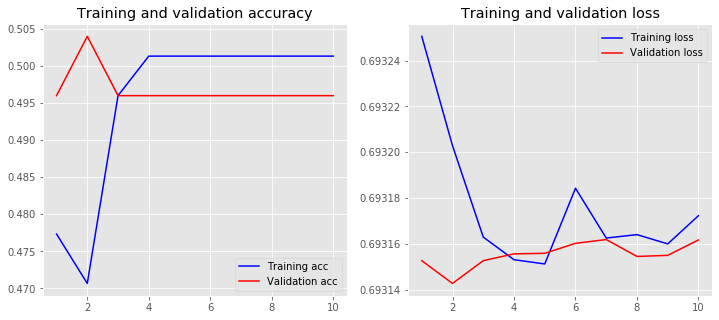

In [139]:
evaluation_(Model_without_first_layer,history_Model_without_first_layer,_for_traingen_[:750],np.array(my_df['Label'][:750]),_for_traingen_[750:1000],np.array(my_df['Label'][750:1000]),with_test=True)

In [88]:
# clear_session()

In [207]:
list(traingen)[i][1]

array([0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1.], dtype=float32)

In [356]:
for_traingen = load_object("for_traingen")

In [203]:
outputs

<tf.Tensor 'bidirectional_10/concat:0' shape=(None, 100, 100) dtype=float32>

In [155]:
# lstm_X_train, lstm_X_test = first_layer_output[:X_train.shape[0]] , first_layer_output[-X_test.shape[0]:]

In [339]:
# for_traingen = (c for c in for_traingen)
# np.concatenate((a, b), axis=None)

In [406]:
df = pd.DataFrame(columns=["ScriptPath","Label"])
x = []
y = []
for i in range(my_batch_size):
    for j in range(len(for_traingen[i][1])-1):
        x.append(for_traingen[i][0][j])
        y.append(for_traingen[i][1][j])
df["ScriptPath"] = x
df["Label"] = y

In [407]:
df.head()

ScriptPath  Label
0  [[-0.00433538, 0.0010302974, 0.0044022035, 0.0...    0.0
1  [[0.0011375259, 0.0073514855, 0.0048887557, -0...    1.0
2  [[-0.0055630635, 0.0036778878, 0.002881036, -0...    1.0
3  [[0.005203909, 0.0037517848, -0.005205665, -0....    1.0
4  [[0.004139867, 0.0064726085, -0.00440897, -0.0...    1.0

In [503]:
class CustomDataGen_(keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,batch_size,test=0,shuffle=True,sub_path="",df_path=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.sub_path = sub_path
        self.n = len(self.df[self.df.columns[0]])
        self.df_path = df_path
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        try:
            with open(self.sub_path+path) as js_file:
                script = js_file.read()
            script = sequence_of_syntax_units(script)
            return script
        except:
            return 'None'
    def __get_output(self, label):
        return label
#         return keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batches):
        if self.df_path == True:
            path_batch = batches[self.X_col['path']]

            name_batch = batches[self.y_col['name']]

            X_batch = np.asarray([self.__get_input(x) for x in path_batch]).astype('object')

            y_batch = np.asarray([self.__get_output(y) for y in name_batch]).astype('object')

            index = np.where(X_batch=='None')[0]

            np.delete(X_batch, index, axis=0)
            np.delete(y_batch, index, axis=0)

            X_batch  = preprocessing_dataset_(X_batch , test = self.test )

            X_batch = K.cast_to_floatx(X_batch)
            y_batch = K.cast_to_floatx(y_batch)
        else:
            
            path_batch = batches[self.X_col['path']]

            name_batch = batches[self.y_col['name']]

            X_batch = np.asarray([path_batch])

            y_batch = np.asarray([name_batch])

            X_batch = K.cast_to_floatx(X_batch)
            y_batch = K.cast_to_floatx(y_batch)
            
            X_batch = X_batch.reshape(20,100,100)
            y_batch = y_batch.reshape(-1,1)

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [505]:
df_for_traingen = CustomDataGen_(df,
                                X_col={'path':'ScriptPath'},
                                y_col={'name': 'Label'},
                                batch_size=my_batch_size,
                                sub_path='G:/JSContanaDataSet/',
                                test=0,
                                df_path = False
                               )

In [507]:
list(df_for_traingen)[1][0].shape

(20, 100, 100)

In [498]:
z.shape

(20, 100, 100)

In [307]:
list(df_for_traingen)[0][0][0][0].shape

(100, 100)

In [508]:
Model_without_first_layer , Model_without_first_layer_history , Model_without_first_layer_name = fit_model(Model_without_first_layer,"Model_without_first_layer",df_for_traingen,with_test=0)

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [157]:
evaluation(Model_without_first_layer,Model_without_first_layer_history,lstm_X_train,y_train,lstm_X_test,y_test)

In [65]:
# clear_session()

In [ ]:
################################################################

AttributeError: 'tuple' object has no attribute 'shape'

In [225]:
for_traingen = np.asarray(for_traingen)

ValueError: could not broadcast input array from shape (20,100,100) into shape (20)

In [ ]:

# file_to_read = open("stored_object.pickle", "rb")

# loaded_object = pickle.load(file_to_read)

# file_to_read.close()
# print(loaded_object)

# ss = np.asarray(["1", "www","2", "None","muawiyua",None,None]).astype('object')
# index = np.where(ss == None)[0]
# print(index)

# np.delete(ss, index, axis=0)

# l = []
# il = []
# i = 0 
# for s in ss:
#     if s!=None:
#         l.append(s)
#         il.append(i)
#     i+=1

# print(np.asarray(l))

In [35]:
# def fit_Model(model,model_name,X_train,y_train,X_test=0,y_test=0,chunk_size=10,with_test=0):
#     model_name = str(model_name)+".h5"
#     X_train_List = chunking_data(X_train,chunk_size)
#     y_train_List = chunking_data(y_train,chunk_size)
   
#     if with_test!=0:
#         X_test_List = chunking_data(X_test,chunk_size)
#         y_test_List = chunking_data(y_test,chunk_size)
#         history = model.fit(X_train_List[0], y_train_List[0],epochs=10,verbose=False,validation_data=(X_test_List[0], y_test_List[0]))
#     else:
#         history = model.fit(X_train_List[0], y_train_List[0],epochs=10,verbose=False)
            
#     model.save(model_name)
#     for i in range(1,len(X_train_List)-1):
#         model = load_model(model_name)
#         if with_test!=0:
#             model.fit(X_train_List[i], y_train_List[i],epochs=10,verbose=False,validation_data=(X_test_List[i], y_test_List[i]))
#         else:
#             model.fit(X_train_List[i], y_train_List[i],epochs=10,verbose=False)
#         loaded_train_test_model.save(model_name)    
#     return model , history , model_name

In [36]:
# def fit_model_(model,model_name,X_train,y_train,X_test=0,y_test=0,with_test=0):
#     model_name = str(model_name)+".h5"
#     if with_test!=0:
#         history = model.fit(X_train, y_train,epochs=10,verbose=False,validation_data=(X_test, y_test))
#     else:
#         history = model.fit(X_train, y_train,epochs=10,verbose=False)
#     model.save(model_name)
#     return model , history , model_name

In [126]:
# my_df = pd.read_csv('G:/JSContanaDataSet/script_path_data.csv')

# traingen = CustomDataGen(my_df.sample(1000),
#                          X_col={'path':'ScriptPath'},
#                          y_col={'name': 'Label'},
#                          batch_size=200,sub_path='G:/JSContanaDataSet/')

In [ ]:
# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)

In [158]:
# path_train_data = 'G:/JSContanaDataSet/script__df.csv'
# # num_words = 400000
# num_words = 400
# # maxlen = 1024
# maxlen = 100
# embedding_dim = 50
# myoptimizer = 'adam'
# myloss= 'binary_crossentropy'
# mymetrics = 'accuracy'


# # sentences_train, sentences_test, y_train, y_test = Read_data_and_split(path_train_data)
# # X_train,X_test = preprocessing_dataset(num_words,sentences_train,sentences_test,maxlen)
# # x_Data = np.concatenate((X_train, X_test), axis=0)
# # y_Data = np.concatenate((y_train, y_test), axis=0)

# Model for All Data

In [212]:
# Model_for_all_data = Model()

In [46]:
# Model_for_all_data , history , model_name = fit_model(Model_for_all_data,"Model_for_all_data",x_Data,y_Data,with_test=0)

In [463]:
# x = []
# y = []
# for i in range(my_batch_size):
#     print("========================")
#     x.append(for_traingen[i][0][0])
#     y.append(for_traingen[i][1][0])
# x = np.array(x)
# y = np.array(y)

In [213]:
# keras_function = K.function([Model_for_all_data.input], [Model_for_all_data.layers[1].output])
# first_layer_output = keras_function([x_Data, 1])
# save('first_layer_output.npy', first_layer_output[0])
# first_layer_output = load('first_layer_output.npy')

In [39]:
# clear_session()

# Model for train&test data

In [19]:
# train_test_Model = Model(vocab_size,embedding_dim,maxlen,myoptimizer,myloss,mymetrics)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1198000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 94, 128)           89728     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 56, 128)           409728    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 128)          

In [20]:
# train_test_Model , train_test_Model_history , train_test_Model_model_name = fit_model(train_test_Model,"train_test_Model",X_train,y_train,X_test,y_test,with_test=1)

Training Accuracy: 0.5040
Testing Accuracy:  0.5240


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.52      0.69       500

    accuracy                           0.52       500
   macro avg       0.50      0.26      0.34       500
weighted avg       1.00      0.52      0.69       500



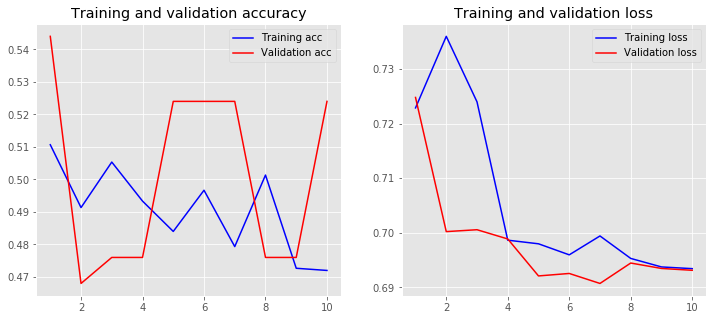

In [21]:
# evaluation(train_test_Model,train_test_Model_history,X_train,y_train,X_test,y_test)

In [ ]:
# clear_session()

# Model Without first LSTM layer

In [22]:
# Model_without_first_layer = Model(vocab_size,embedding_dim,maxlen,myoptimizer,myloss,mymetrics,shape=first_layer_output[0].shape,Type=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 94, 128)           89728     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 128)           573568    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [76]:
# lstm_X_train, lstm_X_test = first_layer_output[:X_train.shape[0]] , first_layer_output[-X_test.shape[0]:]

In [25]:
# Model_without_first_layer , Model_without_first_layer_history , Model_without_first_layer_name = fit_model(Model_without_first_layer,"Model_without_first_layer",lstm_X_train,y_train,lstm_X_test,y_test,with_test=1)

Training Accuracy: 0.5060
Testing Accuracy:  0.5220
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.52      0.69       499

    accuracy                           0.52       500
   macro avg       0.50      0.26      0.34       500
weighted avg       0.99      0.52      0.68       500



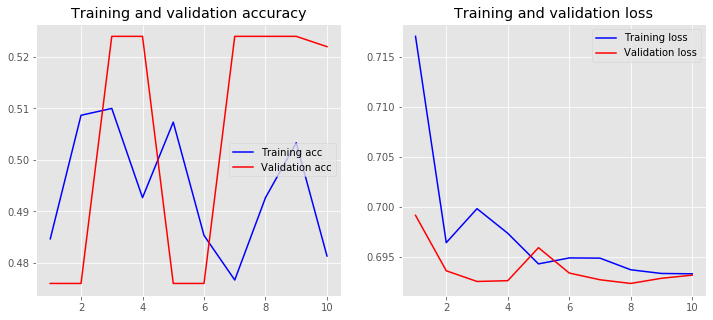

In [26]:
# evaluation(Model_without_first_layer,Model_without_first_layer_history,lstm_X_train,y_train,lstm_X_test,y_test)

In [65]:
# clear_session()

In [ ]:
Model_for_all_data

In [127]:
traingen

In [132]:
print(traingen[0])

['/*\n * The MIT License (MIT)\n * Copyright (c) 2013-2014 Lance Campbell. All rights reserved.\n *\n * Permission is hereby granted, free of charge, to any person obtaining a\n * copy of this software and associated documentation files (the "Software"),\n * to deal in the Software without restriction, including without limitation\n * the rights to use, copy, modify, merge, publish, distribute, sublicense,\n * and/or sell copies of the Software, and to permit persons to whom the\n * Software is furnished to do so, subject to the following conditions:\n *\n * The above copyright notice and this permission notice shall be included in\n * all copies or substantial portions of the Software.\n *\n * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\n * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\n * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\n * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGE

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [115]:
traingen[0][0][0]

'var Promise    = require(\'bluebird\');\nvar ripple     = require(\'ripple-lib\');\nvar moment     = require(\'moment\');\nvar utils      = require(\'../utils\');\nvar Hbase      = require(\'./hbase-thrift\');\nvar Parser     = require(\'../ledgerParser\');\n\nvar SerializedObject = ripple.SerializedObject;\nvar binformat        = ripple.binformat;\n\nvar EPOCH_OFFSET = 946684800;\nvar LI_PAD       = 12;\nvar I_PAD        = 5;\nvar E_PAD        = 3;\nvar S_PAD        = 12;\n\nvar TX_TYPES   = { };\nvar TX_RESULTS = { };\n\nvar exchangeIntervals = [\n  \'1minute\',\n  \'5minute\',\n  \'15minute\',\n  \'30minute\',\n  \'1hour\',\n  \'2hour\',\n  \'4hour\',\n  \'1day\',\n  \'3day\',\n  \'7day\',\n  \'1month\',\n  \'1year\'\n];\n\nObject.keys(binformat.tx).forEach(function(key) {\n  TX_TYPES[key] = binformat.tx[key][0];\n});\n\nObject.keys(binformat.ter).forEach(function(key) {\n  TX_RESULTS[key] = binformat.ter[key];\n});\n\nfunction HbaseClient() {\n  Hbase.apply(this, arguments);\n};\n

In [112]:
my_df.head()

ScriptName  Label
0  { type: "Program", sourceType: "script", body:...      0
1  { type: "Program", sourceType: "script", body:...      1
2  { type: "Program", sourceType: "script", body:...      0
3  { type: "Program", sourceType: "script", body:...      1
4  { type: "Program", sourceType: "script", body:...      0

In [87]:
print(traingen[0][0][0])

'use strict';

describe('jsdoc/tag/dictionary', function() {
    var dictionary = require('jsdoc/tag/dictionary');
    var testDictionary = new dictionary.Dictionary();

    var tagOptions = {
        canHaveValue: true,
        isNamespace: true
    };
    var tagTitle = '!!!testTag!!!';
    var tagSynonym = '!!!testTagSynonym!!!';
    var tagDef = testDictionary.defineTag(tagTitle, tagOptions).synonym(tagSynonym);

    it('should exist', function() {
        expect(dictionary).toBeDefined();
        expect(typeof dictionary).toBe('object');
    });

    it('should be an instance of dictionary.Dictionary', function() {
        expect(dictionary instanceof dictionary.Dictionary).toBe(true);
    });

    it('should export a defineSynonym method', function() {
        expect(dictionary.defineSynonym).toBeDefined();
        expect(typeof dictionary.defineSynonym).toBe('function');
    });

    it('should export a defineTag method', function() {
        expect(dictionary.defineTag).toBeDef

In [23]:
# lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(first_layer_output, y_Data, test_size=0.25, random_state=1000)

In [83]:
first_layer_output.shape[0] == lstm_X_test.shape[0] + lstm_X_train.shape[0]

True

In [81]:
lstm_X_test.shape[0]

14129

In [80]:
X_test.shape[0]

14129

In [79]:
lstm_X_train.shape[0]

42385

In [78]:
X_train.shape[0]

42385

In [77]:
first_layer_output.shape[0] == X_train.shape[0] + X_test.shape[0]

True

14129

In [49]:
first_layer_output[1]

array([[-0.00858213, -0.00033006,  0.00145085, ...,  0.00420958,
         0.03028966,  0.01170124],
       [-0.00628931,  0.01354341, -0.00539014, ...,  0.00651408,
         0.0248036 ,  0.01076141],
       [-0.01052581,  0.01402346, -0.00115174, ...,  0.0135303 ,
         0.02628192,  0.00157341],
       ...,
       [ 0.00090588,  0.00571881, -0.01222495, ...,  0.00225087,
         0.00701454,  0.00421214],
       [ 0.00090588,  0.00571881, -0.01222495, ...,  0.00199938,
         0.00513897,  0.00305712],
       [ 0.00090588,  0.00571881, -0.01222495, ...,  0.00135471,
         0.00285211,  0.00166895]], dtype=float32)

In [28]:
traingen[0]

(array(['dojo.provide("dijit.layout.LinkPane");\n\ndojo.require("dijit.layout.ContentPane");\ndojo.require("dijit._Templated");\n\ndojo.declare("dijit.layout.LinkPane",\n\t[dijit.layout.ContentPane, dijit._Templated],\n\t{\n\t// summary: \n\t//\tA ContentPane that loads data remotely\n\t// description:\n\t//\tLinkPane is just a ContentPane that loads data remotely (via the href attribute),\n\t//\tand has markup similar to an anchor.  The anchor\'s body (the words between `<a>` and `</a>`)\n\t//\tbecome the title of the widget (used for TabContainer, AccordionContainer, etc.)\n\t// example:\n\t//\t<a href="foo.html">my title</a>\n\n\t// I\'m using a template because the user may specify the input as\n\t// <a href="foo.html">title</a>, in which case we need to get rid of the\n\t// <a> because we don\'t want a link.\n\ttemplateString: \'<div class="dijitLinkPane"></div>\',\n\n\t buildRendering: function(){\n\t\tthis.inherited(arguments);\n\n\t\t// make getDescendants() work\n\t\tthis.cont

In [41]:
def preprocessing_dataset(X_train, X_test, max_len=MAX_LENGTH):
    """
    Map tokens to integers to feed them into Embedding layer
    """
    tokenizer = Tokenizer(400000)
    tokenizer.fit_on_texts(X_train)
    X_train_sequence = tokenizer.texts_to_sequences(X_train)
    X_test_sequence = tokenizer.texts_to_sequences(X_test)
    return pad_sequences(X_train_sequence, maxlen=max_len, padding='post'), pad_sequences(X_test_sequence, maxlen=max_len, padding='post')

In [72]:
with open("G:/JSContanaDataSet/programs_training.txt", 'r', encoding='utf-8') as file:
    path_scripts = file.readlines()
script_df = pd.DataFrame(columns=["ScriptName","Label"])
scripts = []
Label = []
for path_script in range(len(path_scripts)-1):
    try:
        s_p = "G:/JSContanaDataSet/"+path_scripts[path_script][:-1]
        with open(s_p) as js_file:
            script = js_file.readlines()
        scripts.append(script)
        if path_script%2==0:
            Label.append(0)
        else:
            Label.append(1)
    except:
        print(i + "_ ")
script_df["ScriptName"] = scripts
script_df["Label"] = Label

NameError: name 'i' is not defined

In [ ]:
script_df.head()

In [63]:
len(path_scripts)

100000

In [56]:
path_scripts

['/* -*- Mode: C++; tab-width: 2; indent-tabs-mode: nil; c-basic-offset: 2 -*- */\n',
 '/* This Source Code Form is subject to the terms of the Mozilla Public\n',
 ' * License, v. 2.0. If a copy of the MPL was not distributed with this\n',
 ' * file, You can obtain one at http://mozilla.org/MPL/2.0/. */\n',
 '\n',
 "var gTestfile = 'regress-472450-04.js';\n",
 '//-----------------------------------------------------------------------------\n',
 'var BUGNUMBER = 472450;\n',
 "var summary = 'TM: Do not assert: StackBase(fp) + blockDepth == regs.sp';\n",
 "var actual = '';\n",
 "var expect = '';\n",
 '\n',
 '\n',
 '//-----------------------------------------------------------------------------\n',
 'test();\n',
 '//-----------------------------------------------------------------------------\n',
 '\n',
 'function test()\n',
 '{\n',
 "  enterFunc ('test');\n",
 '  printBugNumber(BUGNUMBER);\n',
 '  printStatus (summary);\n',
 ' \n',
 '  jit(true);\n',
 '\n',
 '  ({__proto__: #1=[#1#]});\n'

In [ ]:
print('number of scripts {}'.format(len(scripts)))
clean_scripts = []
for sc in scripts:
    try:
        #parse the response HTML page
        clean_scripts.append(extract_js_code(sc.strip()))
    except:
        print(sc)
clean_scripts = list(filter(lambda x: len(x)>0, clean_scripts))
print('number of clean scripts: {}'.format(len(clean_scripts)))

In [ ]:
dataset = []
for sc in clean_scripts:
    for s in sc:
        try:
            sequence_of_syntax_units(s)
            dataset.append(s)
        except:
            print(sc)

In [ ]:
target = [1] * 181

In [ ]:
len(dataset)

In [ ]:
outputs = [layer.output for layer in model.layers]
outputs

In [ ]:
plot_model(model, show_shapes=True)

In [74]:
# test sequence_of_syntax_units 
test_script = """
var fs = Npm.require("fs");

Package.describe({
  name: 'arch:ace-editor',
  summary: 'Integrating Ace editor with Meteor since 2015',
  version: '1.1.1',
  git: 'https://github.com/0a-/meteor-ace-editor'
});

Package.onUse(function(api) {
  api.versionsFrom('1.0.2.1');
  api.use('tracker', 'client');
  var files = fs.readdirSync('ace-builds/src-noconflict');
  files.forEach(function(file){
    if(file.substr(-3)===".js"){
        api.add_files("ace-builds/src-noconflict/"+file, "client", {isAsset: true});
    }
  });
  api.addFiles('core.js','client');
  api.export('AceEditor','client');
});

Package.onTest(function(api) {
  api.use('tinytest');
  api.use('arch:ace-editor');
  api.addFiles('tests.js','client');
});

"""
sequence_of_syntax_units(test_script)

'{ type: "Program", sourceType: "script", body: [ { type: "VariableDeclaration", declarations: [ { type: "VariableDeclarator", id: { type: "Identifier", name: "fs" }, init: { type: "CallExpression", callee: { type: "MemberExpression", computed: False, object: { type: "Identifier", name: "Npm" }, property: { type: "Identifier", name: "require" } }, arguments: [ { type: "Literal", value: "fs", raw: "\\"fs\\"" } ] } } ], kind: "var" }, { type: "ExpressionStatement", expression: { type: "CallExpression", callee: { type: "MemberExpression", computed: False, object: { type: "Identifier", name: "Package" }, property: { type: "Identifier", name: "describe" } }, arguments: [ { type: "ObjectExpression", properties: [ { type: "Property", key: { type: "Identifier", name: "name" }, computed: False, value: { type: "Literal", value: "arch:ace-editor", raw: "\'arch:ace-editor\'" }, kind: "init", method: False, shorthand: False }, { type: "Property", key: { type: "Identifier", name: "summary" }, comput

In [73]:
# convert java script code to the abstract syntax tree
# then extract the sequences of syntax units with detailed information
def sequence_of_syntax_units(scripts):
    """
    sctipts : list or single javascript code 
    return sequence of syntax units
    each syntax unit correspond to line in an abstract syntax tree
    """
    if type(scripts) is list:
        # esp.parseScript(script) returns abstract syntax tree of each js scripts
        return [re.sub('\s+', ' ', ''.join(str(esp.parseScript(script)).split('\n'))) for script in scripts]
    elif type(scripts) is str:
        return re.sub('\s+', ' ', ''.join(str(esp.parseScript(scripts)).split('\n')))
    else:
        raise ValueError('The type of scripts parameter must be {list or string}')

In [ ]:
def pipeline():
    
    Model_for_all_data = Model(vocab_size,embedding_dim,maxlen,myoptimizer,myloss,mymetrics)
    Model_for_all_data , history , model_name = fit_model(Model_for_all_data,"Model_for_all_data",x_Data,y_Data,with_test=0)
    
    keras_function = K.function([Model_for_all_data.input], [Model_for_all_data.layers[1].output])
    first_layer_output = keras_function([x_Data, 1])
    save('first_layer_output.npy', first_layer_output[0])
    first_layer_output = load('first_layer_output.npy') 
    